# ESPEI

### Extensible Self-optimizating Phase Equilibria Infrastructure

Documentation for internal and external APIs can be found at https://espei.org

Solutions to this notebook can be found at https://github.com/materialsgenomefoundation/2021-workshop-material


In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import corner
from pycalphad import Database, equilibrium, variables as v
from pycalphad.plot.utils import phase_legend
from espei.datasets import load_datasets, recursive_glob
from espei.utils import database_symbols_to_fit, optimal_parameters
from uq_helpers import highest_density_parameters

dbf = Database('mcmc-start.tdb')
comps = ['CR', 'NI']
datasets = load_datasets(recursive_glob('input-data', '*.json'))
trace = np.load('Cr-Ni-trace.npy')
lnprob = np.load('Cr-Ni-lnprob.npy')
symbols_to_fit = database_symbols_to_fit(dbf)

## Uncertainty quantification

### Corner plot

Text(0.5, 0.98, '40 chains; 600 iterations of burn in')

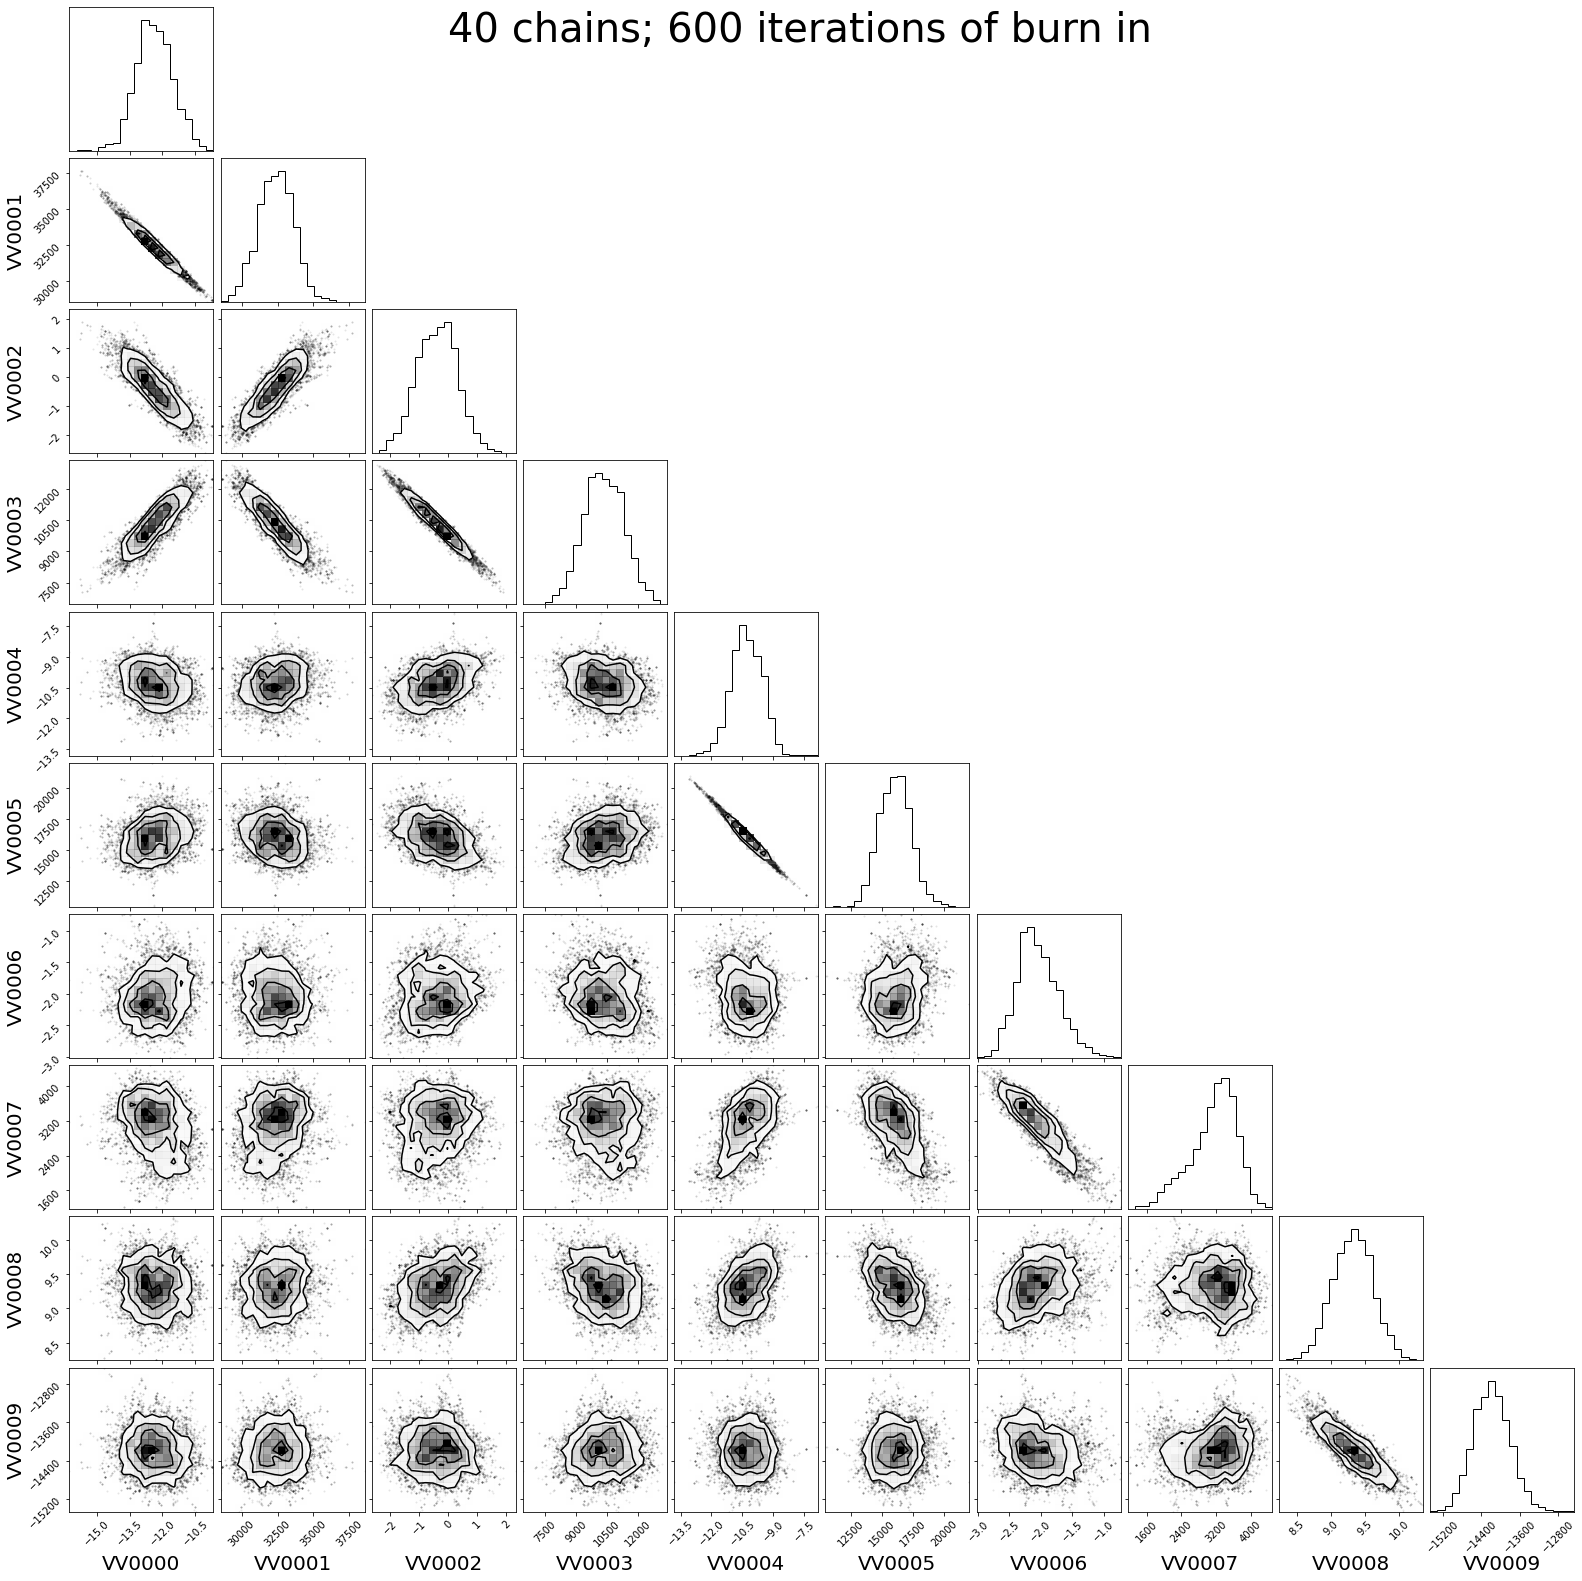

In [3]:
burnin = 600  # first non-burn-in index (discard previous)
fig = corner.corner(trace[:,burnin:,:].reshape(-1, trace[:,burnin:,:].shape[-1]), labels=sorted(symbols_to_fit), label_kwargs={'fontsize': 20})
fig.suptitle(f"{trace.shape[0]} chains; {burnin} iterations of burn in", fontsize=40)

## Uncertainty propagation

### BCC_A2 enthalpy of mixing

In [4]:
phases = ['BCC_A2']
conds = {v.P: 101325, v.N: 1, v.T: 2000.0, v.X('NI'): (0, 1, 0.02)}
prop = 'HM_MIX'
flat_params = highest_density_parameters(trace, lnprob, burn_in=600, thin=200)

# Loop over all the parameter sets in flat_params and perform the foward (propagation) calculation
t1 = time.time()
eq_results = []
for param_idx in range(flat_params.shape[0]):
    parameters = dict(zip(symbols_to_fit, flat_params[param_idx, :]))
    eq_res = equilibrium(dbf, comps, phases, conds, output=prop, parameters=parameters)
    eq_results.append(eq_res)
print(f'Time to compute equilibrium uncertainty for {prop} with conditions {conds}: {time.time() - t1:0.2f} seconds')
    
# Concatenate all the parameter samples on a new dimension
eq_up_result = xr.concat(eq_results, 'samples')

# Compute the "optimal" property
params = dict(zip(database_symbols_to_fit(dbf), optimal_parameters(trace, lnprob)))
dbf.symbols.update(params)
eq_opt_result = equilibrium(dbf, comps, phases, conds, output=prop, parameters=params)

Time to compute equilibrium uncertainty for HM_MIX with conditions {P: 101325, N: 1, T: 2000.0, X_NI: (0, 1, 0.02)}: 1.73 seconds


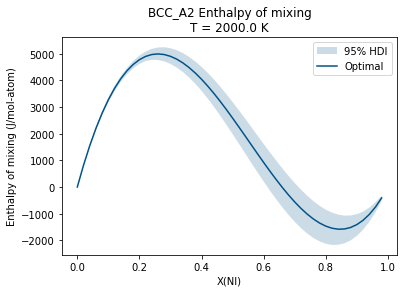

In [5]:
_hndls, colors = phase_legend(phases)
eq_prop = eq_up_result[prop].squeeze()
fig = plt.figure()
ax = fig.add_subplot()
# Single phase assumption (no miscibility gap)
ax.fill_between(eq_up_result.X_NI, eq_prop.min(dim='samples'), eq_prop.max(dim='samples'), alpha=0.2, color=colors[phases[0]], edgecolor=None, label='95% HDI')
ax.plot(eq_opt_result.X_NI, eq_opt_result[prop].squeeze(), color=colors[phases[0]], label='Optimal')
ax.set_title(f'{phases[0]} Enthalpy of mixing\nT = {conds[v.T]} K')
ax.set_ylabel('Enthalpy of mixing (J/mol-atom)')
ax.set_xlabel('X(NI)')
ax.legend(loc=0)

### Phase Fraction vs. Temperature

In [6]:
phases = ['LIQUID', 'FCC_A1', 'BCC_A2']
conds = {v.P: 101325, v.N: 1, v.T: (1000, 2300, 10), v.X('NI'): 0.20}
flat_params = highest_density_parameters(trace, lnprob, burn_in=600, thin=500)

# Loop over all the parameter sets in flat_params and perform the foward (propagation) calculation
t1 = time.time()
eq_results = []
for param_idx in range(flat_params.shape[0]):
    parameters = dict(zip(symbols_to_fit, flat_params[param_idx, :]))
    eq_res = equilibrium(dbf, comps, phases, conds, parameters=parameters)
    eq_results.append(eq_res)
print(f'Time to compute equilibrium uncertainty for NP with conditions {conds}: {time.time() - t1:0.2f} seconds')

# Concatenate all the parameter samples on a new dimension
eq_up_result = xr.concat(eq_results, 'samples')

# Compute the "optimal" property
params = dict(zip(database_symbols_to_fit(dbf), optimal_parameters(trace, lnprob)))
dbf.symbols.update(params)
eq_opt_result = equilibrium(dbf, comps, phases, conds, parameters=params)

Time to compute equilibrium uncertainty for NP with conditions {P: 101325, N: 1, T: (1000, 2300, 10), X_NI: 0.2}: 1.99 seconds


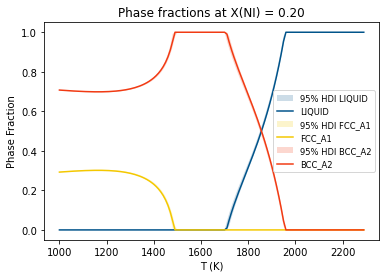

In [7]:
_hndls, colors = phase_legend(phases)
prop = 'NP'
fig = plt.figure()
ax = fig.add_subplot()
for phase_name in phases:
    msk = eq_up_result.Phase == phase_name
    eq_prop = eq_up_result[prop].where(msk).sum(dim='vertex').squeeze()  # WARNING: sum here implies no miscibility gaps
    ax.fill_between(eq_up_result.T, eq_prop.min(dim='samples'), eq_prop.max(dim='samples'), alpha=0.2, color=colors[phase_name], edgecolor=None, label=f'95% HDI {phase_name}')
    ax.plot(eq_opt_result.T, eq_opt_result[prop].where(eq_opt_result.Phase == phase_name).sum(dim='vertex').squeeze(), label=phase_name, color=colors[phase_name])
ax.set_title(f'Phase fractions at X(NI) = {conds[v.X("NI")]:0.2f}')
ax.set_ylabel('Phase Fraction')
ax.set_xlabel('T (K)')
ax.legend(loc=0, fontsize='small')

(1400.0, 1800.0)

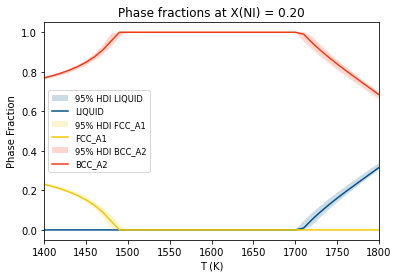

In [8]:
_hndls, colors = phase_legend(phases)
prop = 'NP'
fig = plt.figure()
ax = fig.add_subplot()
for phase_name in phases:
    msk = eq_up_result.Phase == phase_name
    eq_prop = eq_up_result[prop].where(msk).sum(dim='vertex').squeeze()  # WARNING: sum here implies no miscibility gaps
    ax.fill_between(eq_up_result.T, eq_prop.min(dim='samples'), eq_prop.max(dim='samples'), alpha=0.2, color=colors[phase_name], edgecolor=None, label=f'95% HDI {phase_name}')
    ax.plot(eq_opt_result.T, eq_opt_result[prop].where(eq_opt_result.Phase == phase_name).sum(dim='vertex').squeeze(), label=phase_name, color=colors[phase_name])
ax.set_title(f'Phase fractions at X(NI) = {conds[v.X("NI")]:0.2f}')
ax.set_ylabel('Phase Fraction')
ax.set_xlabel('T (K)')
ax.legend(loc=0, fontsize='small')
ax.set_xlim(1400, 1800)